# Downloading Data from Git

In [1]:
! curl -O https://raw.githubusercontent.com/gaylorav/NLPFinal/main/bg_descriptions.csv
! ls

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18.1M  100 18.1M    0     0   9.8M      0  0:00:01  0:00:01 --:--:--  9.8M
bg_descriptions.csv  sample_data


#Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
nltk.download('popular')
nltk.download('punkt_tab')
import re
from nltk import ngrams
from collections import defaultdict
import string

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

# Selecting Relevant Columns From CSV -> PD

In [3]:
descriptions_df = pd.read_csv("bg_descriptions.csv", encoding="utf-8")
#descriptions_df['id'] = descriptions_df['id'].astype(int)
#descriptions_df['usersrated'] = descriptions_df['usersrated'].astype(int)
#descriptions_df['average'] = descriptions_df['average'].astype(float)
#descriptions_df['sentiment'] = descriptions_df['sentiment'].astype(int)

print(len(descriptions_df))
descriptions_df.head()

15589


,id,description,usersrated,average,name,sentiment
0,13,"In CATAN (formerly The Settlers of Catan), pla...",132477,7.09526,CATAN,1
1,822,Carcassonne is a tile placement game in which ...,131182,7.41145,Carcassonne,1
2,30549,"In Pandemic, several virulent diseases have br...",128935,7.52913,Pandemic,1
3,68448,You are the leader of one of the 7 great citie...,107506,7.67463,7 Wonders,1
4,167791,"In the 2400s, mankind begins to terraform the ...",103923,8.35266,Terraforming Mars,1


# Analyzing Distribution of Board Game Ratings

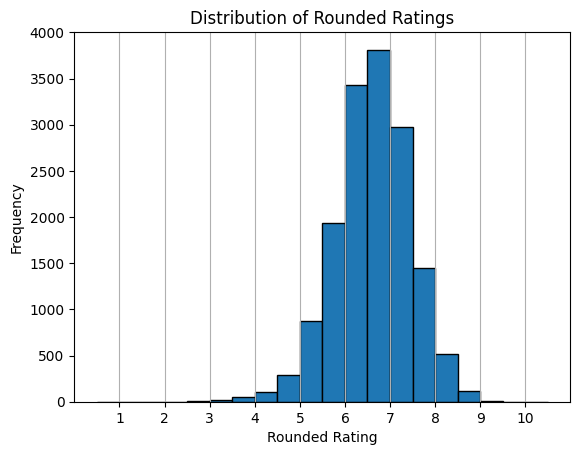

In [4]:
rounded_ratings = descriptions_df["average"]

# Plot the histogram
descriptions_df["average"].hist(bins=[0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0, 10.5], edgecolor='black')
plt.xlabel("Rounded Rating")
plt.ylabel("Frequency")
plt.title("Distribution of Rounded Ratings")
plt.xticks([1,2,3,4,5,6,7,8,9,10])
plt.grid(axis='y')
plt.show()

In [5]:
stoplist = stopwords.words('english')
stoplist = stoplist + list(string.punctuation) + ["'s", "n't"]
stoplist = set(stoplist)

pattern = re.compile(r'^[^A-Za-z0-9\s]+$')

word_lens = []
words = []

for d in descriptions_df["description"]:
  d = nltk.word_tokenize(d)
  word_lens.append(len(d))
  for word in d:
    word = word.lower()
    if word not in stoplist and not pattern.match(word):
      words.append(word)

In [6]:
print(descriptions_df["usersrated"].median())
print(descriptions_df["usersrated"].mean())
print(sum(word_lens) / len(word_lens))
df_words = pd.Series(words).value_counts().reset_index()
df_words.columns = ['word', 'frequency']
df_words.head(50)
#df_words.to_csv('bg_word_counts.csv', index=False)
#from google.colab import files
#files.download('bg_word_counts.csv')  # replace with your file

337.0
1635.871896850343
229.9239207133235


,word,frequency
0,game,40040
1,players,26400
2,cards,22443
3,player,22073
4,one,17111
5,card,13809
6,play,9872
7,points,9230
8,new,7911
9,turn,7802


# RNN-LSTM Analysis

In [7]:
#Analyzing game rating based on description using an RNN model
#Implement RNN using Keras
from sklearn.model_selection import train_test_split

import tensorflow
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences



### 1. Preprocess data for LSTM

In [8]:
#First step is padding all input to be the same length (necessary for RNN)
#So find longest description, and pad all other reviews to be the same length

descriptions = descriptions_df["description"]

#tokenizer.fit_on_texts will create a vocabulary from our descriptions
#vocab will be ordered by frequency (most frequent word will be "1", etc.)
#vocab is limited to top 5000 frequent words by default
tokenizer = Tokenizer(num_words=10000) #need more words, doubled to 10k
tokenizer.fit_on_texts(descriptions)

#each description is mapped onto the numbers corresponding to each word in the description
#(basically we turned our descriptions into numbers)
int_descriptions = tokenizer.texts_to_sequences(descriptions)


#pad data so that each sequence is length of the longest description sequence
MAX_LEN = max([len(desc) for desc in int_descriptions])    #*********POTENTIAL*********
desc_data = pad_sequences(int_descriptions, maxlen=MAX_LEN, padding='post')




#one-hot encode sentiment categories
#i.e., if a game is "positively" rated, [0,0,1]
descriptions_df['sentiment'] = descriptions_df['sentiment'].astype(int)
labels = descriptions_df['sentiment'].values
sentiments = np.array([(label + 1) for label in labels])
ratings = to_categorical(sentiments, num_classes=3)

#check encoding worked:
print(descriptions_df['sentiment'].tail())
print(sentiments[-5:])
print(ratings[-5:])

#split data into 80 = train, 20 = temp
#split temp into 10 = validate, 10 = test
train_desc, temp_desc = train_test_split(desc_data, test_size=0.2, random_state=42, shuffle=False)
train_rating, temp_rating = train_test_split(ratings, test_size=0.2, random_state=42, shuffle=False)

val_desc, test_desc = train_test_split(temp_desc, test_size=0.5, random_state=42, shuffle=False)
val_rating, test_rating = train_test_split(temp_rating, test_size=0.5, random_state=42, shuffle=False)




15584   -1
15585    1
15586    0
15587    1
15588    1
Name: sentiment, dtype: int64
[0 2 1 2 2]
[[1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [9]:
#got paranoid and checked shaped of other data too lol
print(desc_data.shape)
print(train_desc.shape)
print(train_rating.shape)
print(train_rating[-5:])
print(np.argmax(train_rating[-5:], axis = 1))

(15589, 1732)
(12471, 1732)
(12471, 3)
[[1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]
[0 2 2 2 2]


### Defining and Training the Model

In [10]:
from tensorflow.keras.metrics import Recall
from tensorflow.keras.metrics import Precision

#define model
#input dimension:how many words the model can learn (should be our vocab size)
#output dimesnion: size of word embedding vector **************
#LSTM: argument is the number of LSTM units model has (does the learning part of the model)
#Dense: final output layer, arguments are num categories, softmax turns output into prob dist over categories (does actual classificaiton)


INPUT_DIM = 10000 #we chose this earlier when tokenizing
EMBEDDING_DIM = 300 #choose over 100 for larger data set, less than 100 for smaller

model = Sequential([
    Embedding(input_dim=INPUT_DIM, output_dim=EMBEDDING_DIM),
    LSTM(64, recurrent_dropout=0.2, activation='tanh'), #used to be at 64, tried diff number ranging to 256
    Dense(3, activation='softmax')
])


#compile and train model
#model on all data commented rn bc i ran out of time to keep running it, using small one below
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', Precision(), Recall()])
results = model.fit(train_desc, train_rating, epochs=5, batch_size=32, validation_data=(val_desc, val_rating))


Epoch 1/5
390/390 ━━━━━━━━━━━━━━━━━━━━ 1184s 3s/step - accuracy: 0.5885 - loss: 0.9632 - precision: 0.5889 - recall: 0.5629 - val_accuracy: 0.4464 - val_loss: 1.1463 - val_precision: 0.4464 - val_recall: 0.4464
Epoch 2/5
390/390 ━━━━━━━━━━━━━━━━━━━━ 1215s 3s/step - accuracy: 0.5972 - loss: 0.9546 - precision: 0.5971 - recall: 0.5970 - val_accuracy: 0.4464 - val_loss: 1.1230 - val_precision: 0.4464 - val_recall: 0.4464
Epoch 3/5
390/390 ━━━━━━━━━━━━━━━━━━━━ 1205s 3s/step - accuracy: 0.6049 - loss: 0.9444 - precision: 0.6049 - recall: 0.6049 - val_accuracy: 0.4464 - val_loss: 1.1241 - val_precision: 0.4464 - val_recall: 0.4464
Epoch 4/5
390/390 ━━━━━━━━━━━━━━━━━━━━ 1150s 3s/step - accuracy: 0.6051 - loss: 0.9437 - precision: 0.6051 - recall: 0.6051 - val_accuracy: 0.4464 - val_loss: 1.1269 - val_precision: 0.4464 - val_recall: 0.4464
Epoch 5/5
390/390 ━━━━━━━━━━━━━━━━━━━━ 1151s 3s/step - accuracy: 0.6034 - loss: 0.9441 - precision: 0.6034 - recall: 0.6034 - val_accuracy: 0.4464 - val_los

In [11]:
for key in results.history.keys():
  print(key)
  print(results.history[key])

accuracy
[0.6009141206741333, 0.6021168828010559, 0.6021168828010559, 0.6021168828010559, 0.6021168828010559]
loss
[0.9520573019981384, 0.9488226771354675, 0.9480776786804199, 0.947664737701416, 0.9473080039024353]
precision
[0.6020739078521729, 0.6020849943161011, 0.6021168828010559, 0.6021168828010559, 0.6021168828010559]
recall
[0.5959426164627075, 0.602036714553833, 0.6021168828010559, 0.6021168828010559, 0.6021168828010559]
val_accuracy
[0.4464400112628937, 0.4464400112628937, 0.4464400112628937, 0.4464400112628937, 0.4464400112628937]
val_loss
[1.1462546586990356, 1.123040795326233, 1.1240812540054321, 1.1269068717956543, 1.1313772201538086]
val_precision
[0.4464400112628937, 0.4464400112628937, 0.4464400112628937, 0.4464400112628937, 0.4464400112628937]
val_recall
[0.4464400112628937, 0.4464400112628937, 0.4464400112628937, 0.4464400112628937, 0.4464400112628937]


In [12]:
model.evaluate(test_desc, test_rating)

49/49 ━━━━━━━━━━━━━━━━━━━━ 26s 533ms/step - accuracy: 0.4173 - loss: 1.1656 - precision: 0.4173 - recall: 0.4173


[1.145838975906372, 0.4342527389526367, 0.4342527389526367, 0.4342527389526367]

In [14]:
from sklearn.metrics import classification_report
# # check results:
y_pred = model.predict(test_desc)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(val_rating, axis=1)


print(classification_report(y_true, y_pred_classes, target_names=["negative", "neutral", "positive"]))
print(np.unique(np.argmax(y_pred, axis=1), return_counts=True))


49/49 ━━━━━━━━━━━━━━━━━━━━ 31s 623ms/step
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       497
     neutral       0.00      0.00      0.00       366
    positive       0.45      1.00      0.62       696

    accuracy                           0.45      1559
   macro avg       0.15      0.33      0.21      1559
weighted avg       0.20      0.45      0.28      1559

(array([2]), array([1559]))


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
